In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch as th

batch_size = 32

In [3]:
from datetime import datetime 
start_time = datetime.now()





In [4]:
start = time()
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [5]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('../input/annotation/Annotation/',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    #object_img = object_img.resize((64,64), Image.ANTIALIAS)
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)

In [6]:
%%time
database = '../input/all-dogs/all-dogs/'

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform,n_samples=25000)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)

CPU times: user 1min 18s, sys: 4.52 s, total: 1min 22s
Wall time: 2min


In [7]:
len(train_loader)

692

In [8]:
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y


In [9]:
def show_generated_img_all():
    gen_z = torch.randn(32, nz, 1, 1, device=device)
    gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)
    #plt.savefig(filename)  
### This is to show one sample image for iteration of chosing


In [10]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

In [11]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)
        # return the computed values:
        return y

In [12]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        #x= self.conv5(x)
        return x.view(-1, 1)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 256

lr = 0.002
lr_d = 0.001
beta1 = 0.5
epochs = 100
netG = Generator(nz, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999))

lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=epochs//10, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=epochs//10, eta_min=0.00005)


fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.6
fake_label = 0.1
batch_size = train_loader.batch_size

In [15]:
import random
import decimal

real_label = float(decimal.Decimal(random.randrange(70, 120))/100)
fake_label = float(decimal.Decimal(random.randrange(1, 30))/100)

[1/100][0/692] Loss_D: -1.4313 Loss_G: 3.5920 D(x): 0.0232 D(G(z)): 1.0000 / 1.0000
[1/100][500/692] Loss_D: 1.0754 Loss_G: 0.3617 D(x): 0.6023 D(G(z)): 0.7914 / 0.7919



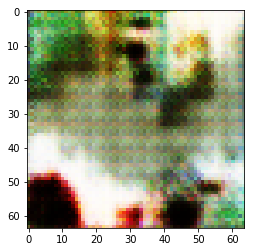

0.85


[2/100][308/692] Loss_D: 0.6670 Loss_G: 0.3661 D(x): 0.4772 D(G(z)): 0.8717 / 0.9217



[3/100][116/692] Loss_D: 1.2604 Loss_G: 0.5003 D(x): 0.3360 D(G(z)): 0.6549 / 0.5894
[3/100][616/692] Loss_D: 1.3721 Loss_G: 0.6741 D(x): 0.4111 D(G(z)): 0.5156 / 0.5435



[4/100][424/692] Loss_D: 1.0441 Loss_G: 0.3838 D(x): 0.5405 D(G(z)): 0.7468 / 0.7969



[5/100][232/692] Loss_D: 1.6555 Loss_G: 0.6664 D(x): 0.6594 D(G(z)): 0.6097 / 0.5549


In [16]:
### training here
g_loss = []
d_loss = []
g_lr = []
d_lr = []

n_disc = 5

step = 0
for epoch in range(epochs):
        
        for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)):
            end = time()
            if (end - start) > 30000 :
                break
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            
            # fliping labels while training discriminator
            if step % 25 == 0:
                #real_label = 0.1
                #fake_label = 0.6
                real_label = float(decimal.Decimal(random.randrange(1, 30))/100)
                fake_label = float(decimal.Decimal(random.randrange(70, 120))/100)              
            
            for numb in range(n_disc):
                netD.zero_grad()
                real_images = real_images.to(device)
                batch_size = real_images.size(0)
                labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(0.01, 0.1)

                output = netD(real_images)
                errD_real = criterion(output, labels)
                errD_real.backward()
                D_x = output.mean().item()

                # train with fake
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake = netG(noise)
                labels.fill_(fake_label) + np.random.uniform(0, 0.2)
                output = netD(fake.detach())
                errD_fake = criterion(output, labels)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                optimizerD.step()

                for param_group in optimizerD.param_groups:
                    d_lr.append(param_group['lr'])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            real_label = float(decimal.Decimal(random.randrange(70, 120))/100)
            fake_label = float(decimal.Decimal(random.randrange(1, 30))/100)
            
            netG.zero_grad()
            labels.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, labels)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            for param_group in optimizerG.param_groups:
                g_lr.append(param_group['lr'])

            if step % 500 == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                      % (epoch + 1, epochs, ii, len(train_loader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                valid_image = netG(fixed_noise)
            step += 1
            lr_schedulerG.step(epoch)
            lr_schedulerD.step(epoch)

            g_loss.append(errG.item())
            d_loss.append(errD.item())

        if epoch % 5 == 0:
            show_generated_img()
            print(real_label)
        


In [17]:
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

In [18]:
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 2:48:09.085010


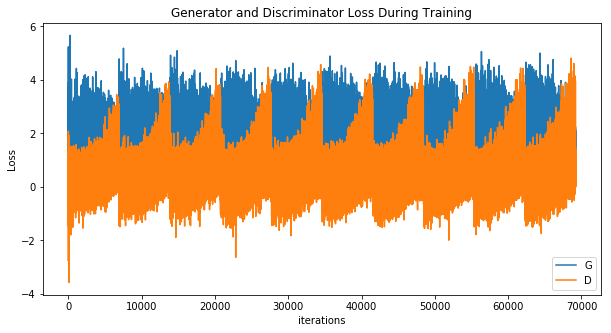

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

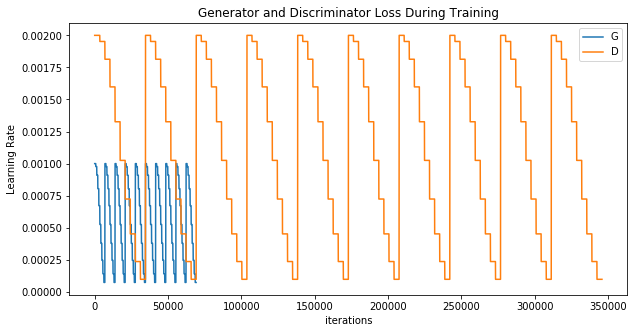

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_lr,label="G")
plt.plot(d_lr,label="D")
plt.xlabel("iterations")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

In [21]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

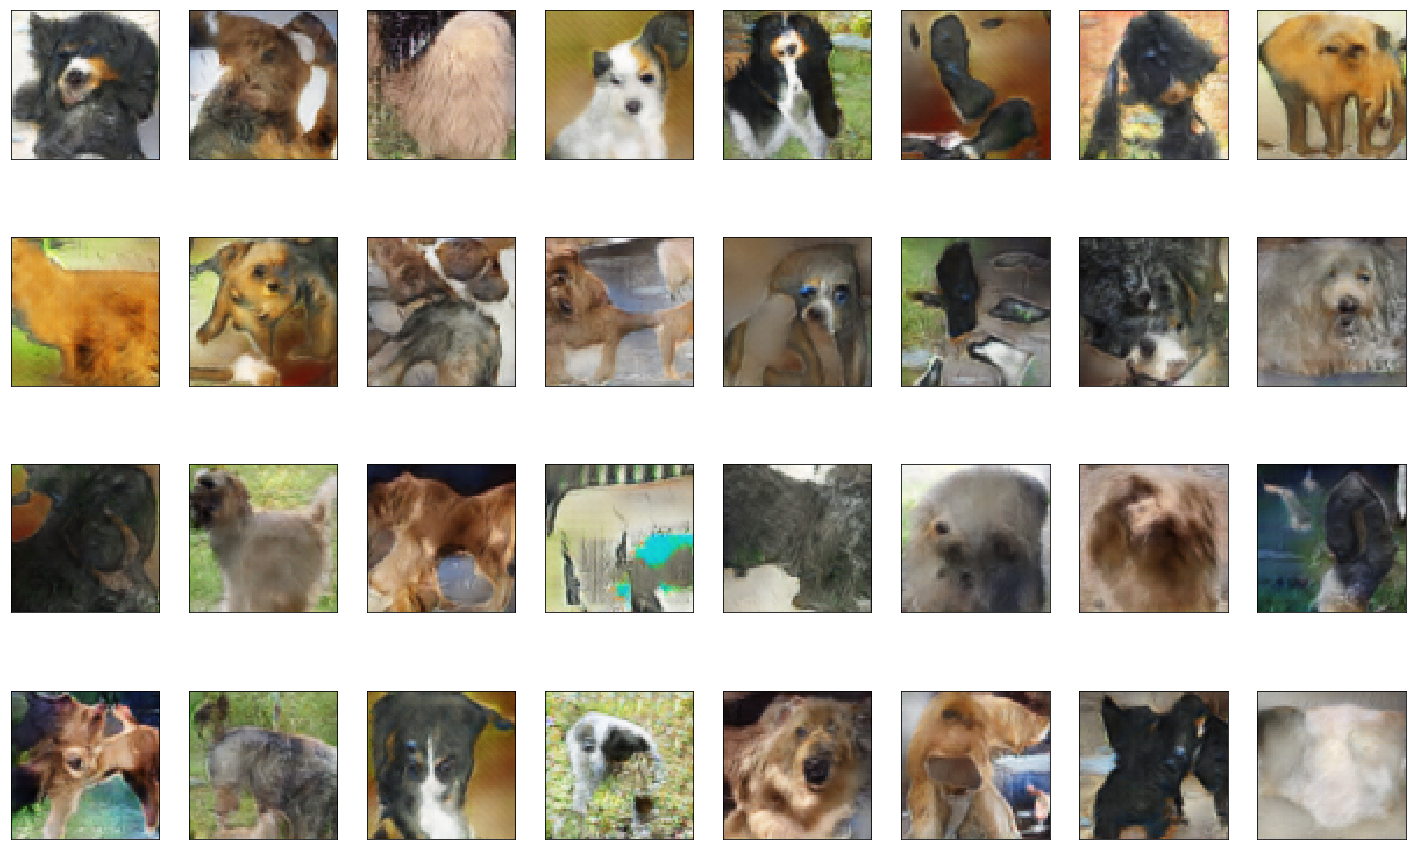

In [22]:
show_generated_img_all()